In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 

import sys 
import os

import multiprocess as mp
from numba import jit

script_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts/'))
sys.path.append(script_dir)
from malts_thresholder import malts_thresholder

# Analysis Settings 

threshold_params = {
    'radius_start': 50, 
    'radius_step': 50, 
    'n_radii': 16, 
    'control_sample_radius': 750, 
    'n_control_samples': 20}

highres_threshold_params = {
    'radius_start': 25, 
    'radius_step': 25, 
    'n_radii': 32, 
    'control_sample_radius': 750, 
    'n_control_samples': 20}

years = [2012, 2017, 2022]
periods = ['S1', 'S2', 'S3']
period_labels = dict(zip(years, periods))
colors = {
    'S1': 'green', 
    'S2': 'blue', 
    'S3': 'purple'}

font = {'family' : 'serif',
         'size'   : 16,
         'serif':  'cmr10'
         }

matplotlib.rc('font', **font)

In [11]:
### Function to run thresholding pipeline 

STRUCTURES = ['abandoned_buildings', 'rail_stations', 'bus_stops', 'public_schools', 'libraries', 'restaurants', 'grocery_stores']

def calculate(structure_name, years, params = threshold_params): 
    for year in years: 
        mt = malts_thresholder(city = 'chi', structure = structure_name, year = year, **params)
        mt.set_treatment(quantile_cut = 0.1)
        mt.fit_malts(
            n_splits = 5,
            n_repeats = 2,
            match_threshold = 2)
        mt.CATE()
        mt.save_tables('tables/')
        print(f'{structure_name} {year}')

In [12]:
### Variance calculation 

@jit(nopython = True)
def var_subroutine(M, treatment, var, outcome, control = False):
    
    if control: 
        treatment = 1 - treatment

    n = M.shape[0]

    mg_size = M @ treatment # number of treatment or control units in mg
    inv_mg_size = np.outer(1/mg_size, 1/mg_size) # matrix m(i, j) = 1/(|mg_i|)(|mg_j|)
    M *= treatment # mask for only treatment of control units
    mg_inter = M @ M.T # matrix m(i, j) = mg_i,t \inter mg_j,t
    # weight_i,j = |mg_i,c inter mg_j,c|/|mg_i,c||mg_j,c|
    w = mg_inter @ inv_mg_size
    np.fill_diagonal(w, 0) # i != j
    w *= outcome.var() # sum_{i != j, control} Cov(T_i, T_j) = sum_{i != j} s_c*weight_i,j

    return (w.sum() + var.sum()) / n**2

def variance(M, treatment, var, outcome):
    '''
        M = np.asarray(df[df['tract_id']])
        M = np.where(M >= 2, 1, 0) # 2 comes from match threshold, change as needed
        treated = np.asarray(df['treatment'])

        var_cols in ndarray with columns in order (radius ascending, control then treatment)
        outcome_cols in ndarray with columns in order 
    '''
    
    pool = mp.Pool()

    d = var.shape[1]
    control = True
    params = []
    for i in range(d):
        if i > var.shape[1] // 2:
            control = False
        params.append([M, treatment, var[:,i], outcome[:,i] , control])
    vars = pool.starmap(var_subroutine, params)
        
    return (vars[:d//2], vars[d//2:])

In [13]:
### Plotting

vars_df = pd.DataFrame()

def plot(structure_name, years, prune = True):
    '''
    Treatment and control series 
    '''

    title = ' '.join(structure_name.split('_')).title()
    fig, ax = plt.subplots()
    ax.set_xlabel('Radius Index')
    ax.set_ylabel('Crime Density')
    plt.title(f'Chicago {title}')

    for year in years: 
        df = pd.read_csv(f'tables/chi_{structure_name}_{year}.csv')
        if prune: 
            max_diameter = df['diameter'].mean() + 2*df['diameter'].std()
            df = df.drop(df[df['diameter'] > max_diameter].index)
            
        n = df.shape[0]
        r = [str(i) for i in range(threshold_params['n_radii'])]

        co_cols = [f'yc_{i}' for i in r]
        to_cols = [f'yt_{i}' for i in r]
        c_avg, t_avg = df[co_cols].mean(), df[to_cols].mean()

        M = np.asarray(df[df['tract_id']])
        M = np.where(M >= 2, 1, 0) # 2 comes from match threshold, change as needed
        M = M.astype(np.float32)
        treatment = np.asarray(df['treatment']).astype(np.float32)
        cv_cols = [f'var_c_{i}' for i in r]
        tv_cols = [f'var_t_{i}' for i in r]
        var = np.asarray(df[cv_cols + tv_cols]).astype(np.float32)
        outcome = np.asarray(df[co_cols + to_cols]).astype(np.float32)
        c_vars, t_vars = variance(M, treatment, var, outcome)
        vars_df[f'{structure_name}_{year}_c'] = c_vars
        vars_df[f'{structure_name}_{year}_t'] = t_vars
        c_sem, t_sem = np.sqrt(c_vars) / n, np.sqrt(t_vars) / n
        
        ax.errorbar(r, t_avg, t_sem, c = colors[period_labels[year]], label = f'{period_labels[year]} Treatment')
        ax.errorbar(r, c_avg, c_sem, c = colors[period_labels[year]], alpha = 0.4, label = f'{period_labels[year]} Control')
        ax.set_xticks(r)

    return fig 

abandoned_buildings
rail_stations
bus_stops
public_schools
libraries
restaurants
grocery_stores


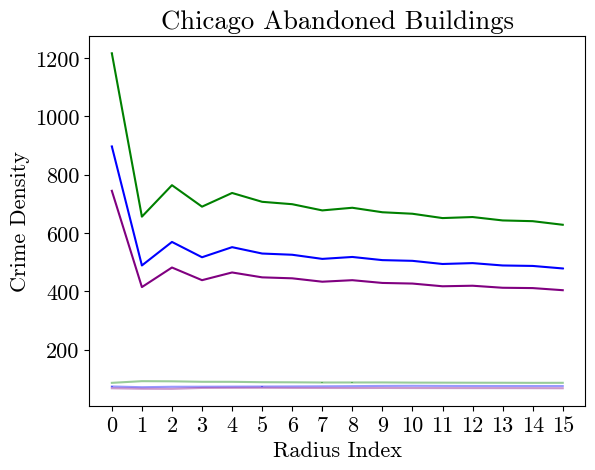

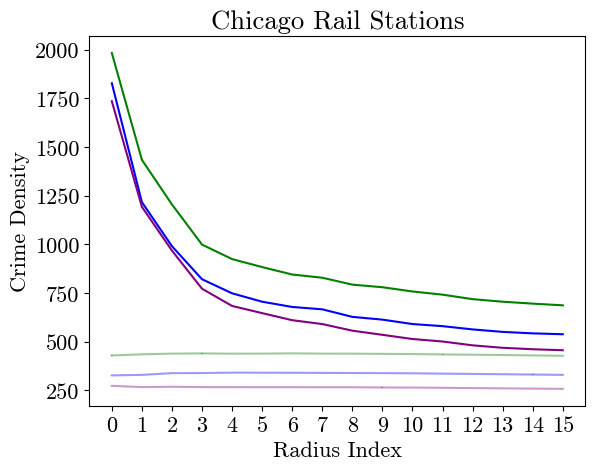

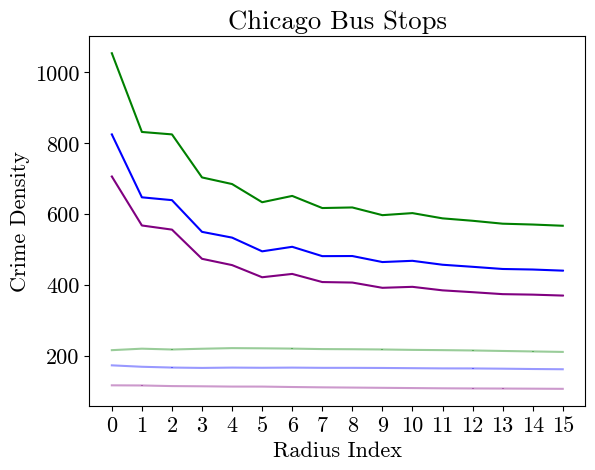

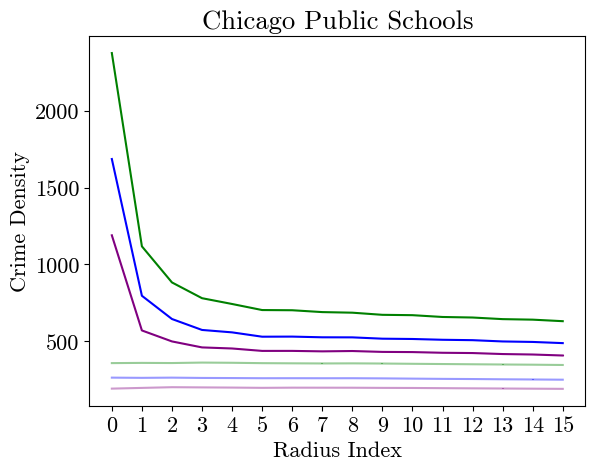

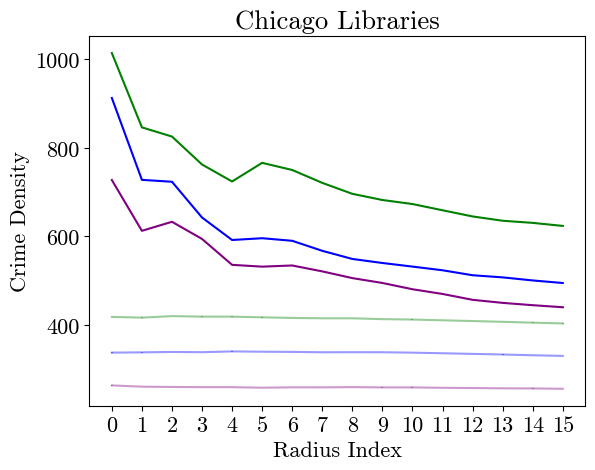

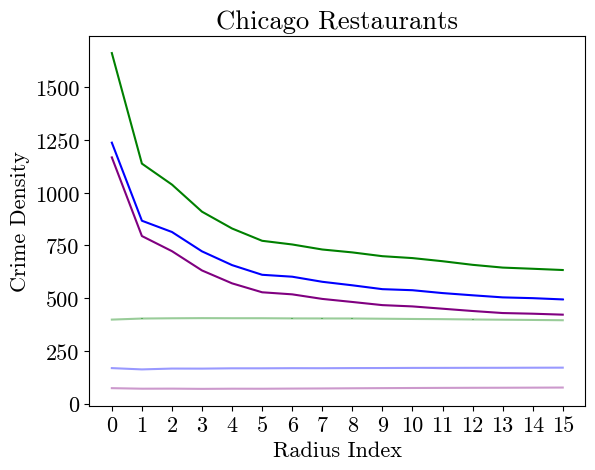

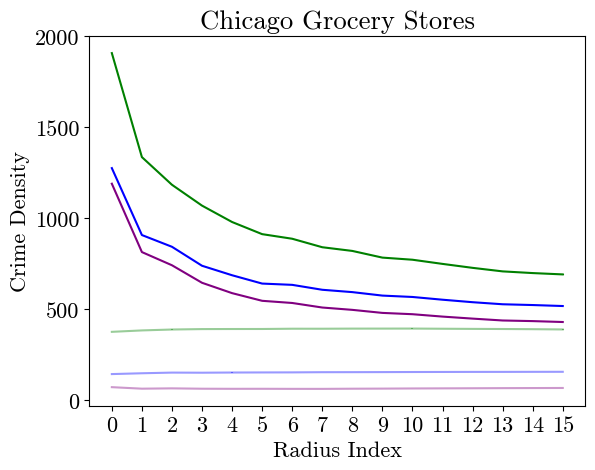

In [14]:
### Plot thresholding results

for structure in STRUCTURES:
    plot(structure, [2012, 2017, 2022]).savefig(f'figures/mt_chicago_{structure}.png')
    print(structure)

vars_df.to_csv('chi_thresholding_vars.csv', index = False)